In [ ]:

import os
import scanpy as sc
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
#from traj_dwt import run_conserved_sample_fitting_pipeline, calculate_trajectory_conservation

# Set matplotlib style
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

# Import from the trajDTW package instead of individual modules
from trajDTW import (
    anndata_to_3d_matrix, 
    calculate_trajectory_conservation,
    TrajectoryFitter,
    get_most_conserved_samples,
    fit_with_conserved_samples,
    create_gene_position_mapping
)


/home/gilberthan/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
output_dir = "/home/gilberthan/Desktop/disk2/202409_tooth/process/trajectory/20250414_epi_run"

In [3]:
epi = sc.read_h5ad("../../../processed_data/integrated_data/20250414_epi_adata.h5ad")
pseudotime_key = "pseudo"
batch_key = "Sample"

gene_to_use = ["Amtn","Ambn","Enam","Odam","Mcm3","Slco5a1"] + list(epi.var_names[0:200])

In [4]:
epi_sub = epi[:,epi.var_names.isin(gene_to_use)]

In [5]:
epi_sub

View of AnnData object with n_obs × n_vars = 49805 × 204
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'nCount_RNA', 'nFeature_RNA', 'coarse_anno_1', 'total_counts', 'log10_total_counts', 'n_genes_detected', 'mito_frac', 'ribo_frac', 'compl', 'size_factors', 'Sample', 'Project', 'Core_datasets', 'Mandibular_Maxillary', 'Molar_Incisor', 'Tooth.position', 'Histology', 'Sex', 'Gene.Type', 'Knockout_gene', 'Cre', 'Treatment', 'FACs', 'Age', 'Stage', 'Development.stage', 'Disease', 'Strain', 'Dissociation_enzyme', 'Machine', 'Species', 'Related.assay', 'Journal', 'Data.Source', 'Data.location', 'new_totals_log', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'scDblFinder_class', 'leiden', 'anno_level_1', 'Cell_ID', 'index', 'leiden_clusters_level_1', 'leiden_clusters_level_2', 'leiden_clusters_level_3', 'leiden_clusters_leve

In [6]:
print("\nConverting to 3D matrix using Gaussian kernel interpolation...")
result = anndata_to_3d_matrix(
    adata=epi_sub,
    pseudo_col='pseudo',     # Column containing pseudotime
    batch_col='Sample',      # Column containing batch information
    n_bins=100,              # Number of interpolation points
    adaptive_kernel=True,    # Use adaptive kernel width
    gene_thred=0.1,          # Filter genes expressed in at least 10% of bins
    batch_thred=0.3,         # Filter batches covering at least 30% of timeline
    ensure_tail=True,        # Ensure batches cover the tail region
    layer = "logcounts"
)
reshaped_data = result["reshaped_data"]


Converting to 3D matrix using Gaussian kernel interpolation...
Calculating bin means in parallel...


[Parallel(n_jobs=36)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=36)]: Done 128 tasks      | elapsed:    1.4s
[Parallel(n_jobs=36)]: Done 378 tasks      | elapsed:    2.1s
[Parallel(n_jobs=36)]: Done 990 out of 990 | elapsed:    3.2s finished


Filtered to 152 genes that meet expression threshold
Batches after coverage filtering: ['Atlas_Jan_incisor_10x', 'Atlas_Jan_incisor_SS2', 'CAGE_Chiba_Epi', 'Cycling_Rapolas_control', 'Epi_Chiba', 'Incisor_Luo_E145', 'Incisor_Luo_E155WT', 'Incisor_Zhang_WT', 'MolarE145_Outie', 'Molar_Qian', 'Runx2_Shuo', 'ToothNc_Junjun_E14.5', 'ToothNc_Junjun_E16.5', 'ToothNc_Junjun_P3.5', 'ToothNc_Junjun_P7.5', 'ToothNiche_Hong_E14.5', 'ToothNiche_Hong_PN7', 'Tooth_Zheng_M2']
Contingency table of unique bins in tail region:
Batch Atlas_Jan_incisor_10x qualified: 17 tail bins > 2.0 threshold
Batch Atlas_Jan_incisor_SS2 qualified: 4 tail bins > 2.0 threshold
Batch CAGE_Chiba_Epi filtered out: 0 tail bins <= 2.0 threshold
Batch Cycling_Rapolas_control qualified: 5 tail bins > 2.0 threshold
Batch Epi_Chiba qualified: 5 tail bins > 2.0 threshold
Batch Incisor_Luo_E145 filtered out: 0 tail bins <= 2.0 threshold
Batch Incisor_Luo_E155WT filtered out: 0 tail bins <= 2.0 threshold
Batch Incisor_Zhang_WT qualif

[Parallel(n_jobs=36)]: Using backend LokyBackend with 36 concurrent workers.
/home/gilberthan/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/home/gilberthan/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/home/gilberthan/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/home/gilberthan/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/home/gilberthan/anacon

Interpolation complete. 3D matrix shape: (11, 100, 152)


[Parallel(n_jobs=36)]: Done 1672 out of 1672 | elapsed:   10.0s finished


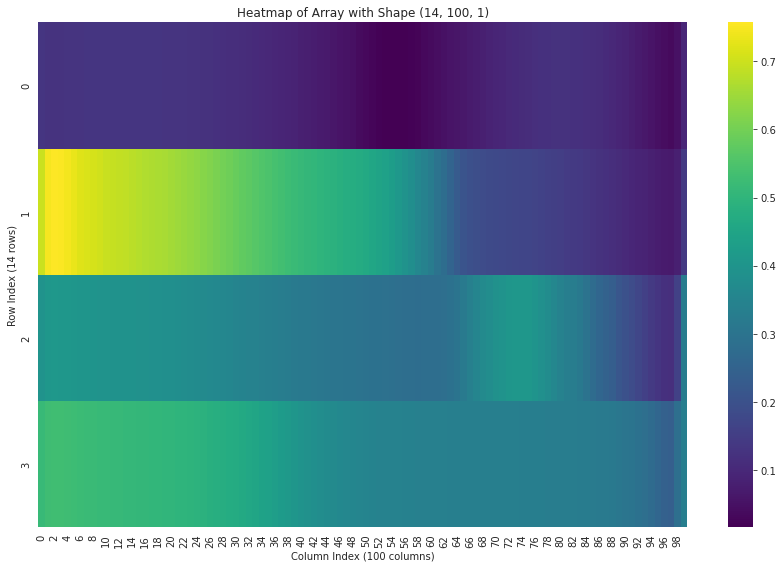

Array shape: (4, 100)
Min value: 0.0163077211154996
Max value: 0.7570646778831313
Mean value: 0.3054088603798768


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create sample data with shape (14, 100, 1)
# You can replace this with your actual data
data = reshaped_data[0:4,0:100,2]

# Reshape the data to 2D since the third dimension is 1
# This will give us a 2D array of shape (14, 100)
data_2d = data.reshape(4, 100)

# Create a figure with a larger size for better visibility
plt.figure(figsize=(12, 8))

# Create the heatmap using seaborn
# 'cmap' determines the color scheme - you can try different options like 'viridis', 'plasma', 'Blues', etc.
sns.heatmap(data_2d, cmap='viridis', cbar=True)

# Add title and labels
plt.title('Heatmap of Array with Shape (14, 100, 1)')
plt.xlabel('Column Index (100 columns)')
plt.ylabel('Row Index (14 rows)')

# Save the figure (optional)


# Show the plot
plt.tight_layout()
plt.show()

# If you want to see specific values in your array, you can print some statistics
print(f"Array shape: {data.shape}")
print(f"Min value: {data.min()}")
print(f"Max value: {data.max()}")
print(f"Mean value: {data.mean()}") 

shape of reshaped_data:  (11, 100, 152)
Start calculating trajectory conservation...
Calculating pairwise DTW distances for 152 genes across 11 samples (55 pairwise comparisons per gene)...
Using normalization method: zscore
Filtering samples by variation: threshold=0.1, metric=max
Processing 152 genes using 36 parallel jobs...


[Parallel(n_jobs=36)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=36)]: Done  81 out of 152 | elapsed:    1.5s remaining:    1.3s
[Parallel(n_jobs=36)]: Done 152 out of 152 | elapsed:    3.3s finished


Debug: all_gene_names length = 152, reshaped_data gene dimension = 152
Creating specialized datasets for each gene...
filtering: top_gene_names ['Lonrf2' 'Ambn' 'Mcm3' '2010300C02Rik' 'Mybl1' 'Enam' 'Slco5a1' 'Rpl31'
 'Rrs1' 'Tex30' 'Sema4c' 'Tram2' 'Rpl7' 'Gpr45' 'Terf1' 'Slc39a10' 'Wdr75'
 'Prim2' 'Hs6st1' 'Mrpl15' 'Amtn' 'Aff3' 'Pdcl3' 'Inpp4a' 'Mrpl30'
 'Crispld1' 'Tmem70' 'Eloc' 'Tpp2' 'Ccdc115' 'Tcea1' 'Mrps9' 'Gulp1'
 'Stau2' 'Cspp1' 'Lactb2' 'Coa5' 'Eif5b' 'Cnot11' 'Cops5' 'Txndc9' 'Fhl2'
 'Lmbrd1' 'Uxs1' 'AI597479' 'Tram1' 'Phf3' 'Cox5b' 'Cnnm3' 'Arhgef4'
 'Tmem14a' 'Dst' 'Ptp4a1' 'Col3a1' 'Pcmtd1' 'Sulf1' 'Rev1' 'Tmem131'
 'Ankrd39' 'Atp6v1h' 'Zfp451' 'Map4k4' 'Mitd1' 'Lypla1' 'Snhg6' 'Rdh10'
 'Sgk3' 'Pi15' 'Fam168b' 'Odam' 'Ogfrl1' 'Tbc1d8' 'Imp4' 'Nck2' 'Rb1cc1'
 'Lman2l' 'Bag2' 'Kansl3' 'Ercc5' 'Uggt1' 'Arfgef1' 'Rnf149' 'Ncoa2'
 'Cnnm4' 'Sdhaf4' 'Vcpip1' 'Unc50' 'Fam135a' 'Col5a2' 'Ptpn18' 'Slc40a1'
 'Smap1' 'Tgfbrap1' 'Ube2w' 'Plekhb2' 'Rab23' 'Arid5a' 'Lipt1' 'Actr1b'
 

RuntimeError: Error fitting models: fit_with_conserved_samples() missing 1 required positional argument: 'filtered_genes'

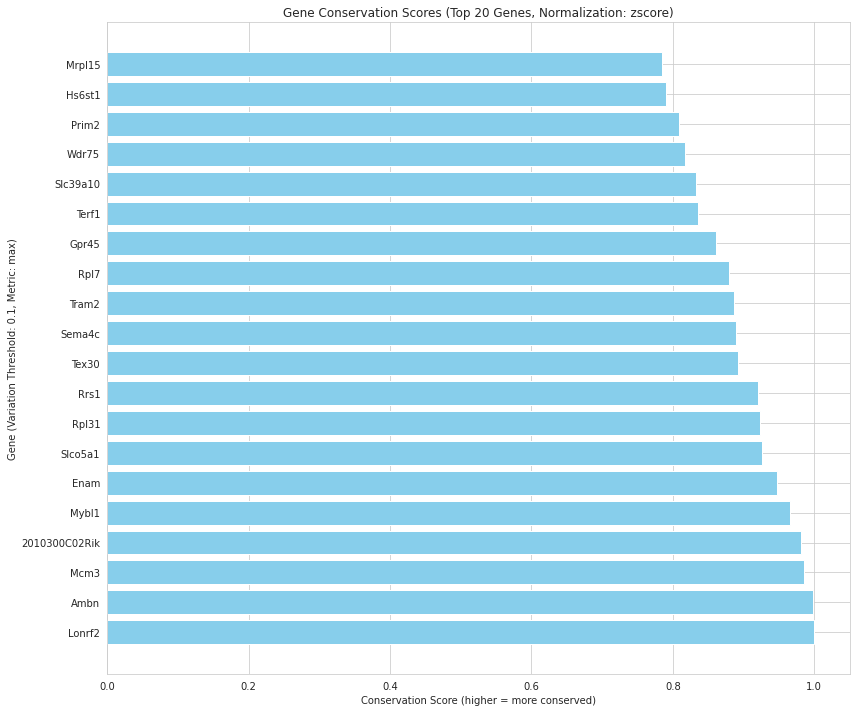

In [9]:
import pandas as pd
reshaped_data = result["reshaped_data"]

# Define sample variation filtering parameters
VARIATION_FILTERING = {
    'off': {
        'filter_samples_by_variation': False
    },
    'basic': {
        'filter_samples_by_variation': True,
        'variation_threshold': 0.1,  # Minimum coefficient of variation
        'variation_metric': 'max',
        'min_valid_samples': 2       # At least 2 samples needed
    },
    'stringent': {
        'filter_samples_by_variation': True,
        'variation_threshold': 0.2, 
        'variation_metric': 'max',
        'min_valid_samples': 2
    }
}

# Choose filtering level
variation_filter_level = 'basic'  # Options: 'off', 'basic', 'stringent'
filter_params = VARIATION_FILTERING[variation_filter_level]
filtered_genes = result['filtered_genes']
print("shape of reshaped_data: ", reshaped_data.shape)
print("Start calculating trajectory conservation...")
conservation_results = calculate_trajectory_conservation(
    trajectory_data=reshaped_data,
    gene_names=filtered_genes, 
    save_dir=output_dir,
    prefix="traj_conservation",
    dtw_radius=3,            # Radius parameter for fastdtw
    use_fastdtw=True,
    normalize='zscore',      # Normalize trajectories before DTW calculation
    **filter_params          # Apply sample variation filtering
)
#_ = extract_pairwise_distances(conservation_results, output_csv = output_dir / "pairwise_distances.csv")

selected_genes = np.array(conservation_results["conservation_scores"]["gene"].head(n=4000))
#conservation_results["conservation_scores"].to_csv(output_dir / "conservation_scores.csv")
fit_res = fit_with_conserved_samples(
    reshaped_data = reshaped_data, filtered_genes = filtered_genes, gene_names = selected_genes, 
    conserved_samples = conservation_results["conserved_samples"], interpolation_factor=1,
    top_n_genes=None, verbose=True, spline_smoothing=2,n_jobs = -1
)

fitdf = pd.DataFrame(fit_res["standard_results"]["fitted_trajectories"])
fitdf.columns = selected_genes

In [10]:

selected_genes = np.array(conservation_results["conservation_scores"]["gene"].head(n=20))
#conservation_results["conservation_scores"].to_csv(output_dir / "conservation_scores.csv")
fit_res = fit_with_conserved_samples(
    reshaped_data = reshaped_data, gene_names = selected_genes, 
    conserved_samples = conservation_results["conserved_samples"], interpolation_factor=1,
    top_n_genes=None, verbose=True, spline_smoothing=2,n_jobs = 1
)

fitdf = pd.DataFrame(fit_res["standard_results"]["fitted_trajectories"])
fitdf.columns = selected_genes

Debug: all_gene_names length = 20, reshaped_data gene dimension = 152
Creating specialized datasets for each gene...
filtering: top_gene_names ['Lonrf2' 'Ambn' 'Mcm3' '2010300C02Rik' 'Mybl1' 'Enam' 'Slco5a1' 'Rpl31'
 'Rrs1' 'Tex30' 'Sema4c' 'Tram2' 'Rpl7' 'Gpr45' 'Terf1' 'Slc39a10' 'Wdr75'
 'Prim2' 'Hs6st1' 'Mrpl15']


RuntimeError: Error fitting models: name 'filtered_genes' is not defined

In [10]:
fitdf.T.loc[["Ambn","Enam"]]

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Ambn,-0.531711,-0.450191,-0.372534,-0.298669,-0.228526,-0.162036,-0.099128,-0.039733,0.016219,0.068798,...,-0.448911,-0.434955,-0.418569,-0.399682,-0.378224,-0.354126,-0.327317,-0.297728,-0.265288,-0.229928
Enam,-0.633200,-0.651301,-0.667497,-0.681829,-0.694334,-0.705053,-0.714026,-0.721291,-0.726889,-0.730859,...,0.720007,0.714935,0.708207,0.699785,0.689630,0.677700,0.663958,0.648363,0.630875,0.611456


In [11]:
selected_genes = filtered_genes[ pd.Series(filtered_genes).isin(selected_genes)]

<Axes: >

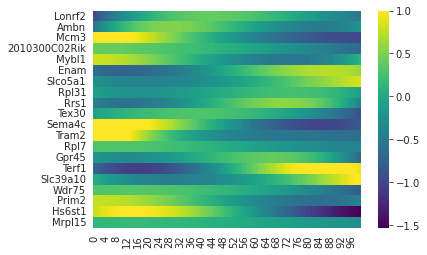

In [12]:
sns.heatmap(fitdf.T, cmap='viridis', cbar=True, vmax = 1)


In [34]:
fit_res3 = fit_with_conserved_samples(
    reshaped_data = reshaped_data, gene_names = selected_genes, 
    conserved_samples = conservation_results["conserved_samples"], interpolation_factor=1,
    top_n_genes=None, verbose=True, spline_smoothing=2,n_jobs = 1
)

fitdf3 = pd.DataFrame(fit_res3["standard_results"]["fitted_trajectories"])
fitdf3.columns = selected_genes

Creating specialized datasets for each gene...
  Gene Mrpl15: Using 5 most conserved samples out of 11 total
  Gene Slco5a1: Using 5 most conserved samples out of 11 total
  Gene Tram2: Using 5 most conserved samples out of 11 total
  Gene 2010300C02Rik: Using 5 most conserved samples out of 11 total
  Gene Tex30: Using 5 most conserved samples out of 11 total
  Gene Enam: Using 5 most conserved samples out of 11 total
Initializing TrajectoryFitter...

Processing 20 genes with 1 parallel jobs...


Processing genes:   0%|          | 0/20 [00:00<?, ?it/s]


Spline Fitting Results Comparison:
Standard approach - mean DTW distance: 54.3155
DTW-optimized approach - mean DTW distance: 54.0810
Improvement: 0.2345
Percentage improvement: 0.43%


In [35]:
fitdf3

,Mrpl15,Rrs1,Mybl1,Slco5a1,Terf1,Rpl7,Mcm3,Tram2,Prim2,Hs6st1,Sema4c,2010300C02Rik,Lonrf2,Rpl31,Gpr45,Tex30,Wdr75,Slc39a10,Ambn,Enam
0,-0.438224,0.324395,0.979587,0.595569,0.733299,-0.538376,0.244861,0.109341,-0.789981,0.454089,1.441210,1.651727,0.837618,-0.706542,-0.753444,0.105312,0.289447,0.743050,0.645144,-0.037817
1,-0.438461,0.322289,0.961014,0.578432,0.736903,-0.561152,0.205542,0.099314,-0.790731,0.451011,1.431492,1.591426,0.797164,-0.631297,-0.805244,0.034612,0.293799,0.741795,0.658930,-0.019336
2,-0.438301,0.320074,0.942343,0.561395,0.738951,-0.581931,0.167991,0.090003,-0.789815,0.447611,1.420201,1.532080,0.758043,-0.559010,-0.852710,-0.032600,0.297836,0.739344,0.671273,-0.001683
3,-0.437748,0.317750,0.923574,0.544459,0.739485,-0.600752,0.132178,0.081389,-0.787281,0.443895,1.407377,1.473684,0.720229,-0.489636,-0.895937,-0.096382,0.301558,0.735729,0.682198,0.015155
4,-0.436809,0.315315,0.904712,0.527628,0.738546,-0.617655,0.098072,0.073451,-0.783176,0.439868,1.393061,1.416232,0.683697,-0.423130,-0.935017,-0.156791,0.304966,0.730982,0.691732,0.031189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.634082,-0.517864,-0.874172,-0.264289,-0.209472,0.695355,0.319094,-0.367099,-0.011807,-0.503161,-0.916600,-0.558185,-0.549877,-0.535460,0.649605,1.036244,-0.687883,-0.293269,-0.938077,-0.349382
96,0.649693,-0.535363,-0.890763,-0.261535,-0.171062,0.684231,0.316015,-0.396876,-0.066828,-0.511896,-0.895480,-0.551821,-0.576456,-0.540247,0.589297,1.041243,-0.712954,-0.265462,-0.946865,-0.357013
97,0.665237,-0.553079,-0.907211,-0.258459,-0.130324,0.671315,0.311902,-0.427805,-0.124705,-0.520422,-0.872097,-0.545014,-0.604101,-0.543717,0.524383,1.044291,-0.738329,-0.235815,-0.954659,-0.364355
98,0.680707,-0.571013,-0.923512,-0.255059,-0.087215,0.656566,0.306726,-0.459906,-0.185485,-0.528733,-0.846412,-0.537769,-0.632837,-0.545823,0.454766,1.045330,-0.764009,-0.204297,-0.961435,-0.371396


<Axes: >

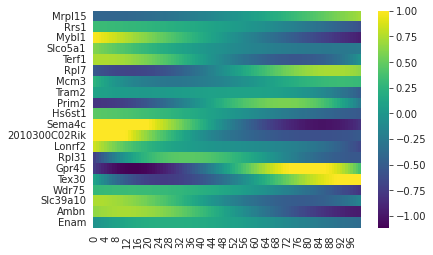

In [36]:
sns.heatmap(fitdf3.T, cmap='viridis', cbar=True, vmax = 1)


In [30]:
fit_res2 = fit_with_conserved_samples(
    reshaped_data = reshaped_data, gene_names = filtered_genes, 
    conserved_samples = conservation_results["conserved_samples"], interpolation_factor=1,
    top_n_genes=None, verbose=True, spline_smoothing=2,n_jobs = -1
)

fitdf2 = pd.DataFrame(fit_res2["standard_results"]["fitted_trajectories"])
fitdf2.columns = filtered_genes




Creating specialized datasets for each gene...
  Gene Xkr4: Using all samples (gene not found in conserved samples dict)
  Gene Sox17: Using all samples (gene not found in conserved samples dict)
  Gene Gm26901: Using all samples (gene not found in conserved samples dict)
  Gene 1700034P13Rik: Using all samples (gene not found in conserved samples dict)
  Gene Mcmdc2: Using all samples (gene not found in conserved samples dict)
  Gene Cpa6: Using all samples (gene not found in conserved samples dict)
  Gene Prex2: Using all samples (gene not found in conserved samples dict)
  Gene A830018L16Rik: Using all samples (gene not found in conserved samples dict)
  Gene Eya1: Using all samples (gene not found in conserved samples dict)
  Gene Kcnb2: Using all samples (gene not found in conserved samples dict)
  Gene Sbspon: Using all samples (gene not found in conserved samples dict)
  Gene Ly96: Using all samples (gene not found in conserved samples dict)
  Gene Jph1: Using all samples (gene 

Processing genes:   0%|          | 0/152 [00:00<?, ?it/s]


Spline Fitting Results Comparison:
Standard approach - mean DTW distance: 44.8872
DTW-optimized approach - mean DTW distance: 44.7851
Improvement: 0.1021
Percentage improvement: 0.23%


In [31]:
fitdf2.T.loc[["Amtn","Ambn","Enam","Odam","Mcm3","Slco5a1"]]

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Amtn,-0.412551,-0.417550,-0.422507,-0.427407,-0.432235,-0.436975,-0.441613,-0.446133,-0.450520,-0.454759,...,1.079508,1.138749,1.199392,1.261450,1.324938,1.389873,1.456268,1.524139,1.593502,1.664370
Ambn,-0.490413,-0.558446,-0.622196,-0.681741,-0.737160,-0.788531,-0.835932,-0.879441,-0.919136,-0.955097,...,1.349723,1.353861,1.355242,1.353787,1.349419,1.342059,1.331628,1.318049,1.301244,1.281133
Enam,-0.596444,-0.665980,-0.730873,-0.791213,-0.847087,-0.898584,-0.945793,-0.988801,-1.027698,-1.062572,...,1.347195,1.341242,1.331972,1.319295,1.303123,1.283368,1.259942,1.232756,1.201721,1.166749
Odam,-0.274981,-0.262014,-0.249431,-0.237224,-0.225388,-0.213916,-0.202802,-0.192038,-0.181620,-0.171539,...,0.114726,0.119034,0.123539,0.128248,0.133167,0.138303,0.143663,0.149251,0.155076,0.161144
Mcm3,2.109360,2.043209,1.977518,1.912296,1.847555,1.783306,1.719559,1.656325,1.593615,1.531440,...,-0.739102,-0.720767,-0.701003,-0.679800,-0.657146,-0.633030,-0.607443,-0.580372,-0.551808,-0.521740
Slco5a1,1.058458,1.035793,1.012889,0.989756,0.966407,0.942853,0.919105,0.895175,0.871075,0.846815,...,-0.590149,-0.588328,-0.585713,-0.582290,-0.578050,-0.572979,-0.567068,-0.560304,-0.552675,-0.544171


In [25]:
filtered_genes[np.isin(filtered_genes, selected_genes)]

array(['Mrpl15', 'Rrs1', 'Mybl1', 'Slco5a1', 'Terf1', 'Rpl7', 'Mcm3',
       'Tram2', 'Prim2', 'Hs6st1', 'Sema4c', '2010300C02Rik', 'Lonrf2',
       'Rpl31', 'Gpr45', 'Tex30', 'Wdr75', 'Slc39a10', 'Ambn', 'Enam'],
      dtype=object)

In [12]:
selected_genes

array(['Lonrf2', 'Ambn', 'Mcm3', '2010300C02Rik', 'Mybl1', 'Enam',
       'Slco5a1', 'Rpl31', 'Rrs1', 'Tex30', 'Sema4c', 'Tram2', 'Rpl7',
       'Gpr45', 'Terf1', 'Slc39a10', 'Wdr75', 'Prim2', 'Hs6st1', 'Mrpl15'],
      dtype=object)

In [13]:
fit_res["top_gene_names"]

['Lonrf2',
 'Ambn',
 'Mcm3',
 '2010300C02Rik',
 'Mybl1',
 'Enam',
 'Slco5a1',
 'Rpl31',
 'Rrs1',
 'Tex30',
 'Sema4c',
 'Tram2',
 'Rpl7',
 'Gpr45',
 'Terf1',
 'Slc39a10',
 'Wdr75',
 'Prim2',
 'Hs6st1',
 'Mrpl15']

In [17]:
fit_res.keys()

dict_keys(['standard_results', 'optimized_results', 'top_gene_names', 'top_gene_indices', 'top_genes_data'])

In [18]:
fit_res["top_gene_indices"]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [14]:
fitdf

,Lonrf2,Ambn,Mcm3,2010300C02Rik,Mybl1,Enam,Slco5a1,Rpl31,Rrs1,Tex30,Sema4c,Tram2,Rpl7,Gpr45,Terf1,Slc39a10,Wdr75,Prim2,Hs6st1,Mrpl15
0,-0.925695,-0.531711,1.451890,0.417367,0.806474,-0.633200,-0.249310,-0.092907,-0.451693,-0.083136,1.441210,2.073570,0.284708,-0.190843,-0.690566,0.025617,0.289447,0.758511,0.793234,0.125072
1,-0.857557,-0.450191,1.421487,0.415248,0.804375,-0.651301,-0.267868,-0.111827,-0.475633,-0.064145,1.431492,1.979874,0.288524,-0.211385,-0.740016,-0.008562,0.293799,0.761920,0.821695,0.129543
2,-0.791555,-0.372534,1.390854,0.412906,0.800847,-0.667497,-0.285346,-0.129354,-0.497015,-0.045605,1.420201,1.888451,0.291834,-0.229891,-0.785722,-0.041343,0.297836,0.763979,0.847891,0.133689
3,-0.727662,-0.298669,1.360001,0.410341,0.795931,-0.681829,-0.301760,-0.145519,-0.515902,-0.027521,1.407377,1.799275,0.294646,-0.246415,-0.827759,-0.072742,0.301558,0.764720,0.871860,0.137513
4,-0.665853,-0.228526,1.328938,0.407556,0.789668,-0.694334,-0.317123,-0.160355,-0.532359,-0.009895,1.393061,1.712315,0.296970,-0.261010,-0.866199,-0.102774,0.304966,0.764173,0.893639,0.141021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.437070,-0.354126,-0.961938,-0.609322,-0.096537,0.677700,0.768404,0.012557,-0.128110,-0.742495,-0.916600,-0.601981,-0.395476,-0.408677,1.036170,0.923985,-0.687883,-0.512105,-1.461243,-0.267931
96,-0.457289,-0.327317,-0.965705,-0.627113,-0.051251,0.663958,0.786605,-0.013270,-0.193688,-0.780826,-0.895480,-0.606361,-0.400479,-0.473079,1.010371,0.955029,-0.712954,-0.493904,-1.481679,-0.273862
97,-0.477208,-0.297728,-0.968670,-0.645010,-0.003496,0.648363,0.804485,-0.040667,-0.262765,-0.819916,-0.872097,-0.611163,-0.405152,-0.540493,0.981251,0.986034,-0.738329,-0.474009,-1.500843,-0.279682
98,-0.496800,-0.265288,-0.970822,-0.663011,0.046768,0.630875,0.822029,-0.069665,-0.335404,-0.859768,-0.846412,-0.616415,-0.409487,-0.610972,0.948736,1.016985,-0.764009,-0.452387,-1.518697,-0.285385


In [15]:
epi.layers

Layers with keys: logcounts

In [57]:
fitdfOptimized = pd.DataFrame(fit_res["optimized_results"]["fitted_trajectories"])

In [37]:
fitdfOptimized.T

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.058458,1.035793,1.012889,0.989756,0.966407,0.942853,0.919105,0.895175,0.871075,0.846815,...,-0.590149,-0.588328,-0.585713,-0.582290,-0.578050,-0.572979,-0.567068,-0.560304,-0.552675,-0.544171
1,1.999850,1.953677,1.906459,1.858254,1.809116,1.759103,1.708270,1.656674,1.604372,1.551420,...,-0.718224,-0.709279,-0.700128,-0.690808,-0.681356,-0.671808,-0.662201,-0.652572,-0.642958,-0.633395
2,-0.412551,-0.417550,-0.422507,-0.427407,-0.432235,-0.436975,-0.441613,-0.446133,-0.450520,-0.454759,...,1.079508,1.138749,1.199392,1.261450,1.324938,1.389873,1.456268,1.524139,1.593502,1.664370
3,-0.535500,-0.595307,-0.651451,-0.703991,-0.752986,-0.798496,-0.840579,-0.879297,-0.914708,-0.946871,...,1.358319,1.358591,1.355602,1.349255,1.339451,1.326093,1.309084,1.288324,1.263717,1.235164
4,-0.960453,-0.959698,-0.959888,-0.960934,-0.962745,-0.965233,-0.968307,-0.971878,-0.975857,-0.980153,...,1.255620,1.239344,1.223753,1.209274,1.196334,1.185361,1.176780,1.171021,1.168509,1.169672
5,-0.274981,-0.262014,-0.249431,-0.237224,-0.225388,-0.213916,-0.202802,-0.192038,-0.181620,-0.171539,...,0.114726,0.119034,0.123539,0.128248,0.133167,0.138303,0.143663,0.149251,0.155076,0.161144


In [63]:
fitdf.T.loc[["Amtn","Ambn","Enam","Odam","Mcm3","Slco5a1"]]

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Amtn,-0.412551,-0.417550,-0.422507,-0.427407,-0.432235,-0.436975,-0.441613,-0.446133,-0.450520,-0.454759,...,1.079508,1.138749,1.199392,1.261450,1.324938,1.389873,1.456268,1.524139,1.593502,1.664370
Ambn,-0.490413,-0.558446,-0.622196,-0.681741,-0.737160,-0.788531,-0.835932,-0.879441,-0.919136,-0.955097,...,1.349723,1.353861,1.355242,1.353787,1.349419,1.342059,1.331628,1.318049,1.301244,1.281133
Enam,-0.596444,-0.665980,-0.730873,-0.791213,-0.847087,-0.898584,-0.945793,-0.988801,-1.027698,-1.062572,...,1.347195,1.341242,1.331972,1.319295,1.303123,1.283368,1.259942,1.232756,1.201721,1.166749
Odam,-0.274981,-0.262014,-0.249431,-0.237224,-0.225388,-0.213916,-0.202802,-0.192038,-0.181620,-0.171539,...,0.114726,0.119034,0.123539,0.128248,0.133167,0.138303,0.143663,0.149251,0.155076,0.161144
Mcm3,2.109360,2.043209,1.977518,1.912296,1.847555,1.783306,1.719559,1.656325,1.593615,1.531440,...,-0.739102,-0.720767,-0.701003,-0.679800,-0.657146,-0.633030,-0.607443,-0.580372,-0.551808,-0.521740
Slco5a1,1.058458,1.035793,1.012889,0.989756,0.966407,0.942853,0.919105,0.895175,0.871075,0.846815,...,-0.590149,-0.588328,-0.585713,-0.582290,-0.578050,-0.572979,-0.567068,-0.560304,-0.552675,-0.544171


<Axes: >

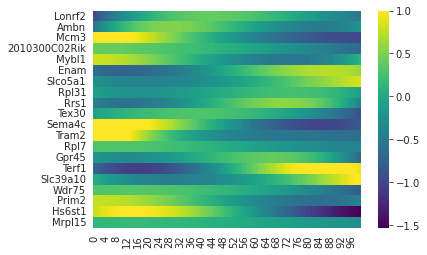

In [16]:

# Create the heatmap using seaborn
# 'cmap' determines the color scheme - you can try different options like 'viridis', 'plasma', 'Blues', etc.
sns.heatmap(fitdf.T, cmap='viridis', cbar=True, vmax = 1)



In [19]:

# Create the heatmap using seaborn
# 'cmap' determines the color scheme - you can try different options like 'viridis', 'plasma', 'Blues', etc.
sns.heatmap(fitdf.T.loc[["Amtn","Ambn","Enam","Odam","Mcm3","Slco5a1"]], cmap='viridis', cbar=True, vmax = 1)



KeyError: "['Amtn', 'Odam'] not in index"

In [ ]:
import scanpy as sc
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from datetime import datetime

# Import from the trajDTW package instead of individual modules
from trajDTW import (
    anndata_to_3d_matrix, 
    calculate_trajectory_conservation,
    TrajectoryFitter,
    get_most_conserved_samples,
    fit_with_conserved_samples,
    extract_pairwise_distances
)

# Set output directory
output_dir = Path("/home/gilberthan/Desktop/disk2/202409_tooth/process/trajectory/20250414_epi_run_3/")
output_dir.mkdir(parents=True, exist_ok=True)

print("\n=== Trajectory Conservation Analysis Pipeline ===\n")
print(f"Results will be saved to: {output_dir}")

# ================ 1. BUILD 3D MATRIX ================
print("\n1. Building 3D Matrix from AnnData")
print("-" * 50)

# Load AnnData
print("Loading AnnData...")
adata = sc.read_h5ad("../../../processed_data/integrated_data/20250414_epi_adata.h5ad")

#adata = adata[:,0:300]
print(f"AnnData shape: {adata.shape}")
# Convert to 3D matrix
print("\nConverting to 3D matrix using Gaussian kernel interpolation...")
result = anndata_to_3d_matrix(
    adata=adata,
    pseudo_col='pseudo',     # Column containing pseudotime
    batch_col='Sample',      # Column containing batch information
    n_bins=100,              # Number of interpolation points
    adaptive_kernel=True,    # Use adaptive kernel width
    gene_thred=0.1,          # Filter genes expressed in at least 10% of bins
    batch_thred=0.3,         # Filter batches covering at least 30% of timeline
    ensure_tail=True,        # Ensure batches cover the tail region
    layer = "logcounts"
)
reshaped_data = result["reshaped_data"]

# Define sample variation filtering parameters
VARIATION_FILTERING = {
    'off': {
        'filter_samples_by_variation': False
    },
    'basic': {
        'filter_samples_by_variation': True,
        'variation_threshold': 0.1,  # Minimum coefficient of variation
        'variation_metric': 'max',
        'min_valid_samples': 2       # At least 2 samples needed
    },
    'stringent': {
        'filter_samples_by_variation': True,
        'variation_threshold': 0.2, 
        'variation_metric': 'max',
        'min_valid_samples': 2
    }
}

# Choose filtering level
variation_filter_level = 'basic'  # Options: 'off', 'basic', 'stringent'
filter_params = VARIATION_FILTERING[variation_filter_level]
filtered_genes = result['filtered_genes']
print("shape of reshaped_data: ", reshaped_data.shape)
print("Start calculating trajectory conservation...")
conservation_results = calculate_trajectory_conservation(
    trajectory_data=reshaped_data,
    gene_names=filtered_genes, 
    save_dir=output_dir,
    prefix="traj_conservation",
    dtw_radius=3,            # Radius parameter for fastdtw
    use_fastdtw=True,
    normalize='zscore',      # Normalize trajectories before DTW calculation
    **filter_params          # Apply sample variation filtering
)
_ = extract_pairwise_distances(conservation_results, output_csv = output_dir / "pairwise_distances.csv")
selected_genes = np.array(conservation_results["conservation_scores"]["gene"].head(n=4000))

conservation_results["conservation_scores"].to_csv(output_dir / "conservation_scores.csv")
fit_res = fit_with_conserved_samples(
    reshaped_data = reshaped_data, gene_names = selected_genes, 
    conserved_samples = conservation_results["conserved_samples"], interpolation_factor=1,
    top_n_genes=None, verbose=True, spline_smoothing=2,n_jobs = -1
)

fitdf = pd.DataFrame(fit_res["standard_results"]["fitted_trajectories"])
fitdf.columns = fit_res["top_gene_names"]

fitdfOptimized = pd.DataFrame(fit_res["optimized_results"]["fitted_trajectories"])
fitdfOptimized.columns = fit_res["top_gene_names"]

fitdf.to_csv(output_dir / "fitted_trajectories.csv")
fitdfOptimized.to_csv(output_dir / "fitted_trajectories_optimized.csv")